In [7]:
import pandas as pd
import numpy as np

# CSV-Datei laden
apps_df = pd.read_csv("input/googleplaystore.csv")

# Entferne fehlerhafte Zeilen (z. B. mit 'Free' in Zahlenspalten)
apps_df = apps_df[apps_df['Installs'].astype(str).str.contains(r'^\d[\d,]*\+$', na=False)]
apps_df = apps_df[apps_df['Price'].astype(str).str.contains(r'^\$?\d+(\.\d{1,2})?$', na=False)]

# Bereinige die 'Installs'-Spalte
apps_df['Installs'] = apps_df['Installs'].str.replace('+', '', regex=False)
apps_df['Installs'] = apps_df['Installs'].str.replace(',', '', regex=False).astype(int)

# Bereinige die 'Price'-Spalte
apps_df['Price'] = apps_df['Price'].str.replace('$', '', regex=False).astype(float)

# Bereinige die 'Reviews'-Spalte
apps_df['Reviews'] = apps_df['Reviews'].astype(str).str.replace(',', '').astype(int)

# Bereinige die 'Size'-Spalte
def parse_size(size):
    if isinstance(size, str):
        if 'M' in size:
            return float(size.replace('M', '').replace(',', '')) * 1_000_000
        elif 'k' in size or 'K' in size:
            return float(size.replace('k', '').replace('K', '').replace(',', '')) * 1_000
    return np.nan

apps_df['Size'] = apps_df['Size'].apply(parse_size)
apps_df = apps_df.dropna(subset=['Size'])

# Zielvariable: Erfolgreich = 1, wenn >= 1.000.000 Downloads
apps_df['is_successful'] = (apps_df['Installs'] >= 1_000_000).astype(int)

# Zeige dir die ersten Zeilen
print(apps_df[['App', 'Category', 'Installs', 'Reviews', 'Price', 'Size', 'is_successful']].head())


                                                 App        Category  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN   
1                                Coloring book moana  ART_AND_DESIGN   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN   
3                              Sketch - Draw & Paint  ART_AND_DESIGN   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN   

   Installs  Reviews  Price        Size  is_successful  
0     10000      159    0.0  19000000.0              0  
1    500000      967    0.0  14000000.0              0  
2   5000000    87510    0.0   8700000.0              1  
3  50000000   215644    0.0  25000000.0              1  
4    100000      967    0.0   2800000.0              0  


/var/folders/_0/9685wbq50hq47s46lsfcx4x00000gn/T/ipykernel_62554/3275148880.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  apps_df = apps_df[apps_df['Price'].astype(str).str.contains(r'^\$?\d+(\.\d{1,2})?$', na=False)]


In [13]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Schritt 1: Eingabefeatures auswählen
features = ['Reviews', 'Price', 'Size']
X = apps_df[features]
y = apps_df['is_successful']

# Schritt 2: Trainings- und Testdaten splitten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Schritt 3: Modelltraining (Random Forest)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Schritt 4: Vorhersage & Auswertung
y_pred = model.predict(X_test)

# Schritt 5: Ergebnisse anzeigen
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[1207   48]
 [  40  534]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1255
           1       0.92      0.93      0.92       574

    accuracy                           0.95      1829
   macro avg       0.94      0.95      0.94      1829
weighted avg       0.95      0.95      0.95      1829



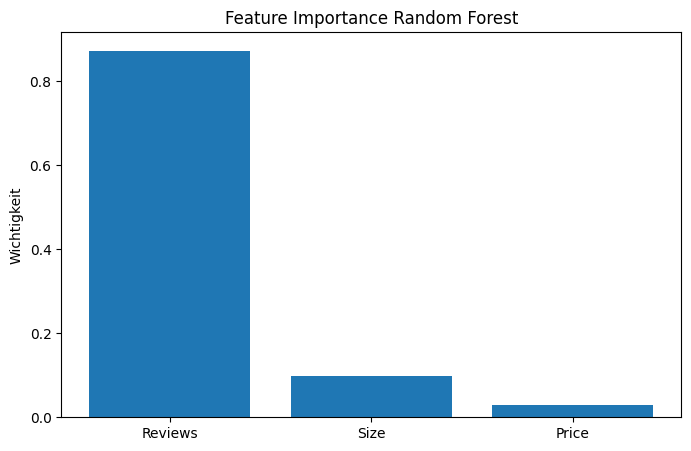

In [15]:
import matplotlib.pyplot as plt
import numpy as np

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.title("Feature Importance Random Forest")
plt.bar(range(len(features)), importances[indices], align='center')
plt.xticks(range(len(features)), [features[i] for i in indices])
plt.ylabel("Wichtigkeit")
plt.show()


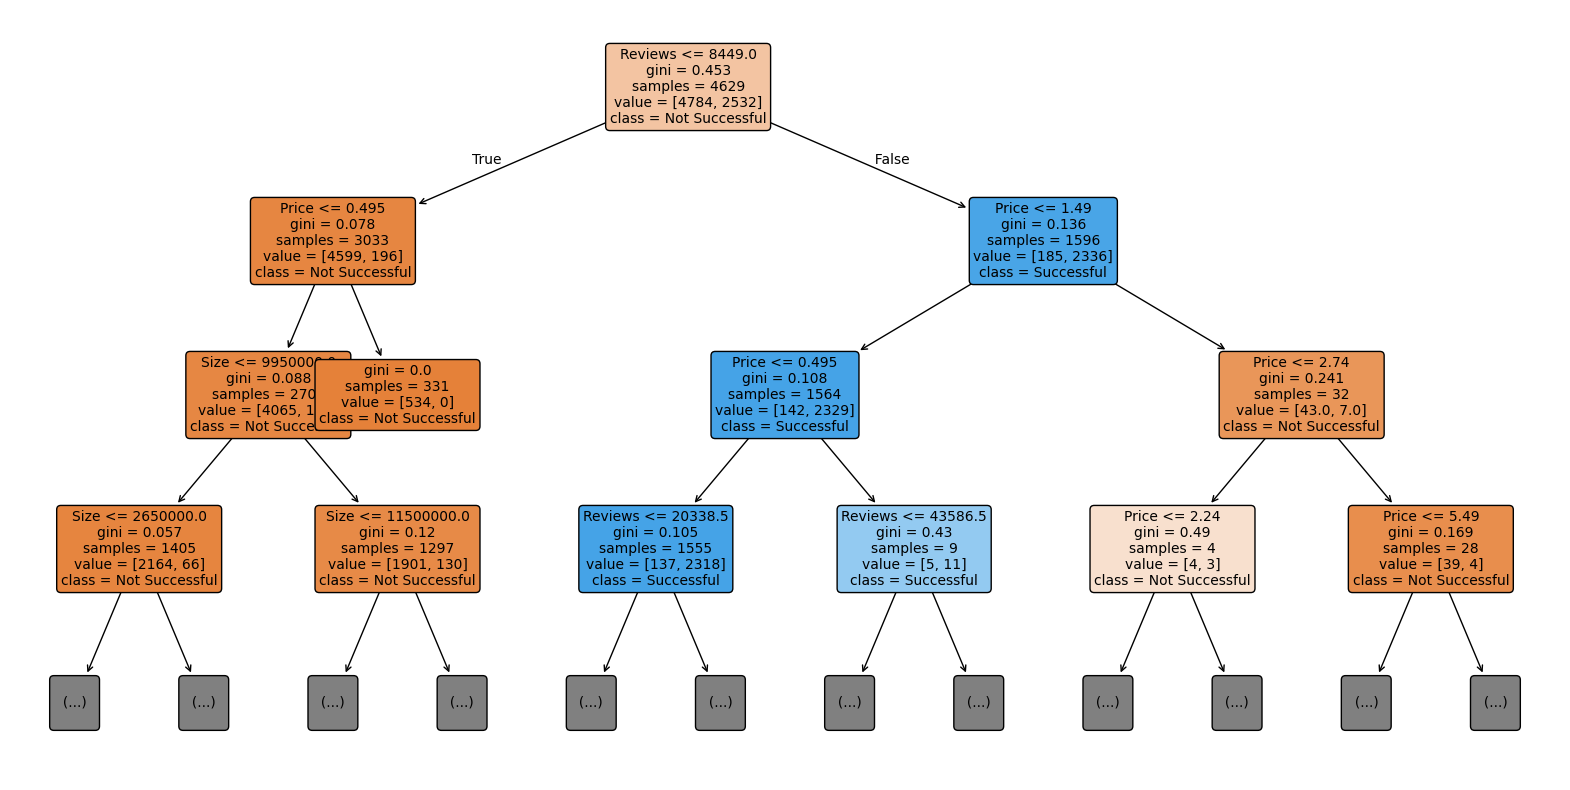

In [19]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Wähle den ersten Baum im Random Forest
estimator = model.estimators_[0]

plt.figure(figsize=(20,10))
plot_tree(estimator,
          feature_names=features,
          class_names=['Not Successful', 'Successful'],
          filled=True,
          rounded=True,
          max_depth=3,    # nur 3 Ebenen anzeigen
          fontsize=10)

plt.show()


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Modell erstellen & trainieren
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Vorhersage
y_pred_logreg = logreg.predict(X_test)

# Evaluation
print("Logistic Regression:")
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))


Logistic Regression:
[[1232   23]
 [  66  508]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1255
           1       0.96      0.89      0.92       574

    accuracy                           0.95      1829
   macro avg       0.95      0.93      0.94      1829
weighted avg       0.95      0.95      0.95      1829



In [21]:
from sklearn.ensemble import HistGradientBoostingClassifier

# Modell erstellen & trainieren
gbc = HistGradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

# Vorhersage
y_pred_gbc = gbc.predict(X_test)

# Evaluation
print("Gradient Boosting Classifier:")
print(confusion_matrix(y_test, y_pred_gbc))
print(classification_report(y_test, y_pred_gbc))


Gradient Boosting Classifier:
[[1209   46]
 [  33  541]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1255
           1       0.92      0.94      0.93       574

    accuracy                           0.96      1829
   macro avg       0.95      0.95      0.95      1829
weighted avg       0.96      0.96      0.96      1829



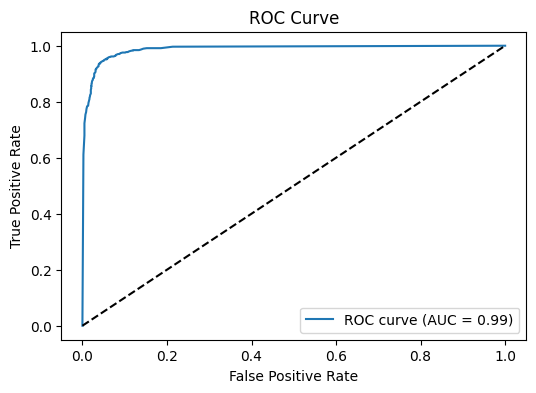

In [22]:
from sklearn.metrics import roc_curve, auc

y_prob = model.predict_proba(X_test)[:,1]  # Wahrscheinlichkeiten für Klasse 1
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()



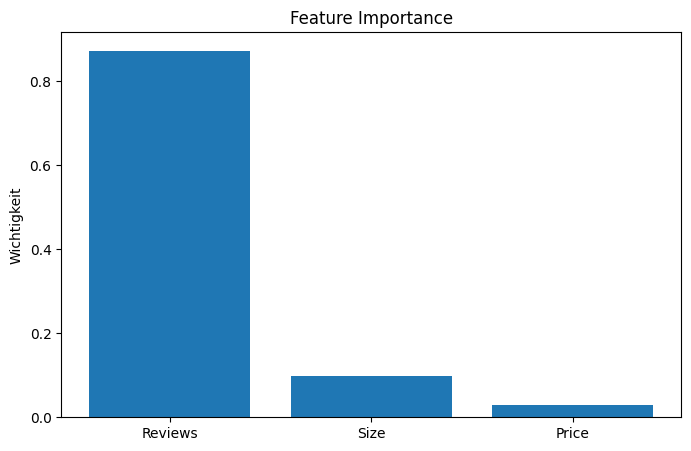

In [23]:
import numpy as np

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.title("Feature Importance")
plt.bar(range(len(features)), importances[indices], align='center')
plt.xticks(range(len(features)), [features[i] for i in indices])
plt.ylabel("Wichtigkeit")
plt.show()
